In [1]:
# !gdown --id 1GaTMURqIQTjtalbNVAyVgPIEis21A0r8
!gdown 1GaTMURqIQTjtalbNVAyVgPIEis21A0r8

Downloading...
From (original): https://drive.google.com/uc?id=1GaTMURqIQTjtalbNVAyVgPIEis21A0r8
From (redirected): https://drive.google.com/uc?id=1GaTMURqIQTjtalbNVAyVgPIEis21A0r8&confirm=t&uuid=a41eb38d-00a3-41ce-9e25-463b32269362
To: /content/FER-2013.zip
100% 63.3M/63.3M [00:01<00:00, 37.3MB/s]


In [2]:
!unzip -q './FER-2013.zip'

In [3]:
import cv2  # Thư viện OpenCV: Sử dụng cho xử lý hình ảnh
import os  # Thư viện os: Làm việc với hệ điều hành (ví dụ: đường dẫn file)
import numpy as np  # Thư viện NumPy: Tính toán toán học trên mảng
import pandas as pd  # Thư viện Pandas: Xử lý dữ liệu dạng bảng
import matplotlib.pyplot as plt  # Thư viện Matplotlib: Vẽ đồ thị

import torch                                # Thư viện PyTorch: Dùng cho học sâu
import torch.nn as nn                       # Module neural network của PyTorch
import torch.nn.functional as F             # Các hàm toán học trong PyTorch
from torch.utils.data import Dataset, DataLoader  # Tạo dataset và DataLoader trong PyTorch
from torchvision.transforms import Resize   # Thay đổi kích thước hình ảnh
from torchvision.io import read_image       # Đọc hình ảnh

from sklearn.model_selection import train_test_split  # Chia tập dữ liệu thành tập huấn luyện và tập kiểm tra
from sklearn.preprocessing import StandardScaler  # Chuẩn hóa dữ liệu (scaling)

# **3. Cài đặt giá trị ngẫu nhiên cố định và thiết bị tính toán:**

In [4]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')  # Thiết lập thiết bị tính toán (GPU hoặc CPU)

random_state = 59                   # Giữ nguyên ngẫu nhiên cho các phép thử
np.random.seed(random_state)        # Đặt hạt giống cho NumPy
torch.manual_seed(random_state)     # Đặt hạt giống cho PyTorch

if torch.cuda.is_available():       # Nếu có GPU
    torch.cuda.manual_seed(random_state)  # Đặt hạt giống cho GPU

# **4. Đọc số lượng class trong dataset**

In [37]:
train_dir = '/content/train'    # Đường dẫn đến thư mục dữ liệu huấn luyện
test_dir = '/content/test'      # Đường dẫn đến thư mục dữ liệu kiểm tra
classes = os.listdir(train_dir) # Danh sách các lớp (thư mục con) trong thư mục huấn luyện

label2idx = {cls: idx for idx, cls in enumerate(classes)}  # Từ điển ánh xạ tên lớp thành chỉ số
idx2label = {idx: cls for cls, idx in label2idx.items()}   # Từ điển ánh xạ chỉ số thành tên lớp

label2idx, idx2label

({'fear': 0,
  'neutral': 1,
  'happy': 2,
  'sad': 3,
  'angry': 4,
  'surprise': 5,
  'disgust': 6},
 {0: 'fear',
  1: 'neutral',
  2: 'happy',
  3: 'sad',
  4: 'angry',
  5: 'surprise',
  6: 'disgust'})

# **5. Xây dựng DataLoader:**

DataLoader là một lớp trong PyTorch giúp ta quản lý và load dữ liệu hiệu quả trong quá trình huấn luyện mô hình.

Nó nhận đầu vào là một Dataset (ImageDataset) và thực hiện các tác vụ như:
+ Chia dữ liệu thành các batch có kích thước cố định
+ Xáo trộn dữ liệu ngẫu nhiên (shuffle)
+ Load dữ liệu song song để tăng tốc độ huấn luyện
+ Cung cấp một iterator để lặp qua các batch dữ liệu

In [35]:
img_height, img_width = (28, 28)

class ImageDataset(Dataset): # Lớp kế thừa của from torch.utils.data import Dataset
    def __init__(self, img_dir, norm, label2idx, split='train', train_ratio=0.8):
        self.resize = Resize((img_height, img_width))  # Resize images to a fixed size
        self.norm = norm                    # Normalize images
        self.split = split                  # Split type (train, val, or test)
        self.train_ratio = train_ratio      # Ratio of training data
        self.img_dir = img_dir              # Directory containing images
        self.label2idx = label2idx          # Mapping from class name to index
        self.img_paths, self.img_labels = self.read_img_files()  # Read image paths and labels

        if split in ['train', 'val'] and 'train' in img_dir.lower():  # Split data into train and validation sets
            train_data, val_data = train_test_split(
                list(zip(self.img_paths, self.img_labels)),
                train_size=train_ratio,
                random_state=random_state,
                stratify=self.img_labels  # Ensure class distribution is maintained
            )
            if split == 'train':
                self.img_paths, self.img_labels = zip(*train_data)
            elif split == 'val':
                self.img_paths, self.img_labels = zip(*val_data)

    def read_img_files(self):  # Đọc danh sách ảnh và nhãn từ thư mục
        img_paths = []   # List to store image paths
        img_labels = []  # List to store image labels

        # Duyệt qua từng lớp
        for cls in self.label2idx.keys():                   # Iterate over each class
            class_dir = os.path.join(self.img_dir, cls)     # Path to class directory
            # Duyệt qua từng ảnh trong lớp
            for img in os.listdir(class_dir):               # Iterate over images in the class directory
                img_path = os.path.join(class_dir, img)     # Full image path
                img_paths.append(img_path)
                img_labels.append(cls)

        return img_paths, img_labels

    def __len__(self):
        return len(self.img_paths)  # Return the number of images

    def __getitem__(self, idx):
        # Hàm này được gọi khi muốn lấy một mẫu dữ liệu (ảnh và nhãn) từ dataset
        # idx là chỉ số của mẫu dữ liệu

        img_path = self.img_paths[idx]  # Lấy đường dẫn của ảnh
        cls = self.img_labels[idx]      # Lấy nhãn của ảnh

        # from torchvision.io import read_image
        img = self.resize(read_image(img_path))  # Đọc và resize ảnh
        img = img.type(torch.float32)   # Chuyển ảnh thành tensor float32
        label = self.label2idx[cls]     # Lấy chỉ số của nhãn tương ứng
        if self.norm:
            img = (img / 127.5) - 1     # Chuẩn hóa ảnh
        return img, label

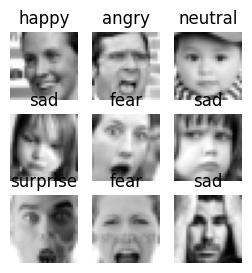

In [36]:
# Tạo các DataLoader
batch_size = 256
train_dataset = ImageDataset(train_dir, True, label2idx, split='train')
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataset = ImageDataset(train_dir, True, label2idx, split='val')
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataset = ImageDataset(test_dir, True, label2idx, split='test')
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Trực quan hóa một batch dữ liệu
image_batch, label_batch = next(iter(train_loader))
plt.figure(figsize=(3, 3))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    minv = image_batch[i].numpy().min()
    maxv = image_batch[i].numpy().max()
    plt.imshow(np.squeeze(image_batch[i].numpy()), vmin=minv, vmax=maxv, cmap="gray")
    label = label_batch[i]
    plt.title(idx2label[label.item()])

    plt.axis("off")
plt.show()

**1. Khai báo lớp mạng MLP (Multi-Layer Perceptron)**

In [32]:
class MLP(nn.Module):
    def __init__(self, input_dims, hidden_dims, output_dims):
        """
        Khởi tạo lớp mạng MLP với các tham số đầu vào, kích thước lớp ẩn và kích thước đầu ra.

        Tham số:
            input_dims (int): Kích thước của vector đầu vào.
            hidden_dims (int): Số lượng neuron trong mỗi lớp ẩn.
            output_dims (int): Kích thước của vector đầu ra (số lượng lớp).
        """
        super(MLP, self).__init__()  # Gọi hàm khởi tạo của lớp cha (nn.Module)

        # Định nghĩa các lớp tuyến tính (linear layers)
        self.linear1 = nn.Linear(input_dims, hidden_dims * 4)  # Lớp 1 với 4 * hidden_dims neuron
        self.linear2 = nn.Linear(hidden_dims * 4, hidden_dims * 2)  # Lớp 2 với 2 * hidden_dims neuron
        self.linear3 = nn.Linear(hidden_dims * 2, hidden_dims)  # Lớp 3 với hidden_dims neuron
        self.output = nn.Linear(hidden_dims, output_dims)  # Lớp đầu ra với output_dims neuron

    def forward(self, x):
        """
        Thực hiện tính toán truyền thẳng (forward pass) trên một mẫu dữ liệu đầu vào (x).

        Tham số:
            x (torch.Tensor): Mẫu dữ liệu đầu vào.

        Trả về:
            torch.Tensor: Kết quả dự đoán của mạng (output layer).
        """
        x = nn.Flatten()(x)  # Làm phẳng dữ liệu đầu vào thành vector (nếu cần thiết)
        x = self.linear1(x)  # Tính toán lớp 1
        x = F.relu(x)  # Hàm kích hoạt ReLU cho lớp 1
        x = self.linear2(x)  # Tính toán lớp 2
        x = F.relu(x)  # Hàm kích hoạt ReLU cho lớp 2
        x = self.linear3(x)  # Tính toán lớp 3
        x = F.relu(x)  # Hàm kích hoạt ReLU cho lớp 3
        out = self.output(x)  # Tính toán lớp đầu ra
        return out.squeeze(1)  # Loại bỏ chiều thứ nhất nếu nó có kích thước 1

***2. Thiết lập các thông số***

In [39]:
# Thiết lập các siêu tham số
hidden_dims = 64 # hidden_dims = Số lượng neuron trong mỗi lớp ẩn của mạng thần kinh.
lr = 1e-2

# Kích thước đầu vào -- Số lượng tham số mỗi lớp newron là:  output = activation(weights * input + bias)
img_height = 28   # Ví dụ: Kích thước chiều cao, chiều rộng của ảnh
img_width  = 28   #  28x28 pixel = 784 neuron
input_dims   = img_height * img_width  # input_dims = số lượng features (đặc trưng)

# Output một lớp trong mạng MLP :
classes = os.listdir(train_dir) # Danh sách các lớp (thư mục con) trong thư mục huấn luyện
output_dims = len(classes)      # output_dims

# Tạo đối tượng MLP
model = MLP(input_dims = input_dims, hidden_dims = hidden_dims, output_dims =output_dims).to(device)

**3. Hàm tính toán Loss và Optimizer**

In [40]:
criterion = nn.CrossEntropyLoss()  # Hàm tính toán loss (Cross-entropy cho phân loại đa lớp)
optimizer = torch.optim.SGD(model.parameters(), lr=lr)  # Optimizer (Stochastic Gradient Descent)

**4. Hàm tính toán độ chính xác**

In [44]:
def compute_accuracy(y_hat, y_true):
    """
    Tính toán độ chính xác của mô hình trên một batch dữ liệu.

    Tham số:
        y_hat (torch.Tensor): Kết quả dự đoán của mô hình.
        y_true (torch.Tensor): Nhãn thực sự của dữ liệu.

    Trả về:
        float: Độ chính xác (tỷ lệ dự đoán đúng).
    """
    _, y_hat = torch.max(y_hat, dim=1)  # Lấy chỉ số lớp có giá trị dự đoán cao nhất
    correct = (y_hat == y_true).sum().item()  # Đếm số dự đoán đúng
    accuracy = correct / len(y_true)
    return accuracy

**9. Huấn luyện mô hình:**


EPOCH 1:	Training loss: 1.663	Validation loss: 1.672

EPOCH 2:	Training loss: 1.657	Validation loss: 1.667

EPOCH 3:	Training loss: 1.652	Validation loss: 1.662

EPOCH 4:	Training loss: 1.647	Validation loss: 1.659

EPOCH 5:	Training loss: 1.641	Validation loss: 1.655

EPOCH 6:	Training loss: 1.637	Validation loss: 1.651

EPOCH 7:	Training loss: 1.633	Validation loss: 1.648

EPOCH 8:	Training loss: 1.629	Validation loss: 1.646

EPOCH 9:	Training loss: 1.625	Validation loss: 1.643

EPOCH 10:	Training loss: 1.622	Validation loss: 1.640

EPOCH 11:	Training loss: 1.618	Validation loss: 1.638

EPOCH 12:	Training loss: 1.615	Validation loss: 1.636

EPOCH 13:	Training loss: 1.612	Validation loss: 1.634

EPOCH 14:	Training loss: 1.609	Validation loss: 1.632

EPOCH 15:	Training loss: 1.606	Validation loss: 1.630

EPOCH 16:	Training loss: 1.604	Validation loss: 1.627

EPOCH 17:	Training loss: 1.600	Validation loss: 1.625

EPOCH 18:	Training loss: 1.598	Validation loss: 1.623

EPOCH 19:	Training

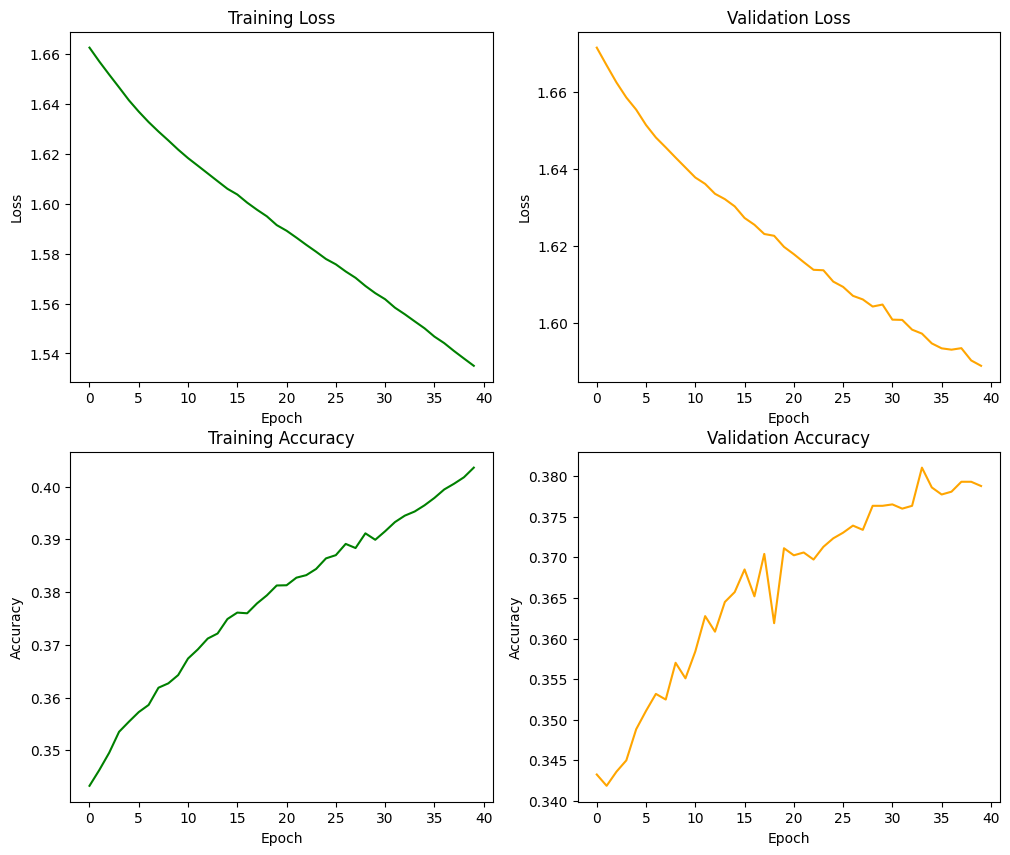

In [45]:
epochs = 40  # Số lượng epoch (vòng lặp huấn luyện)
train_losses = []  # Danh sách để lưu trữ loss huấn luyện của từng epoch
val_losses = []  # Danh sách để lưu trữ loss kiểm định của từng epoch
train_accs = []  # Danh sách để lưu trữ độ chính xác huấn luyện của từng epoch
val_accs = []  # Danh sách để lưu trữ độ chính xác kiểm định của từng epoch

for epoch in range(epochs):
    train_loss = 0.0  # Khởi tạo biến để tính toán tổng loss huấn luyện cho epoch hiện tại
    train_target = []  # Danh sách để lưu trữ nhãn thực sự của dữ liệu huấn luyện
    train_predict = []  # Danh sách để lưu trữ dự đoán của mô hình trên dữ liệu huấn luyện

    model.train()  # Chuyển model sang chế độ huấn luyện (để bật tính năng gradient descent)
    for X_samples, y_samples in train_loader:  # Lặp qua từng batch dữ liệu huấn luyện
        X_samples = X_samples.to(device)  # Chuyển dữ liệu đầu vào vào thiết bị (GPU hoặc CPU)
        y_samples = y_samples.to(device)  # Chuyển nhãn tương ứng vào thiết bị

        optimizer.zero_grad()  # Đặt gradient về 0 trước khi tính toán gradient mới
        outputs = model(X_samples)  # Tiến hành forward pass để tính toán output của mô hình
        loss = criterion(outputs, y_samples)  # Tính toán loss giữa output dự đoán và nhãn thực sự

        # Backpropagation (lan truyền ngược)
        loss.backward()  # Tính toán gradient của loss đối với các tham số của mô hình
        optimizer.step()  # Cập nhật các tham số mô hình dựa trên gradient và learning rate

        train_loss += loss.item()  # Cộng dồn loss của batch hiện tại vào tổng loss của epoch
        train_predict.append(outputs.detach().cpu())  # Lưu trữ dự đoán của mô hình
        train_target.append(y_samples.cpu())  # Lưu trữ nhãn thực sự

    train_loss /= len(train_loader)  # Tính trung bình loss trên toàn bộ dữ liệu huấn luyện
    train_losses.append(train_loss)

    train_predict = torch.cat(train_predict)  # Nối các batch dự đoán thành một tensor
    train_target = torch.cat(train_target)  # Nối các batch nhãn thực sự thành một tensor
    train_acc = compute_accuracy(train_predict, train_target)  # Tính độ chính xác trên dữ liệu huấn luyện
    train_accs.append(train_acc)

    # Phần kiểm định (validation)
    val_loss = 0.0
    val_target = []
    val_predict = []
    model.eval()  # Chuyển model sang chế độ kiểm định (tắt tính năng gradient descent)
    with torch.no_grad():  # Ngăn chặn tính toán gradient trong quá trình kiểm định
        for X_samples, y_samples in val_loader:
            X_samples = X_samples.to(device)
            y_samples = y_samples.to(device)
            outputs = model(X_samples)
            val_loss += criterion(outputs, y_samples).item()
            val_predict.append(outputs.cpu())
            val_target.append(y_samples.cpu())

    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    val_predict = torch.cat(val_predict)
    val_target = torch.cat(val_target)
    val_acc = compute_accuracy(val_predict, val_target)
    val_accs.append(val_acc)

    print(f'\nEPOCH {epoch + 1}:\tTraining loss: {train_loss:.3f}\tValidation loss: {val_loss:.3f}')

# Vẽ đồ thị loss và accuracy
# Visualize training and validation curves
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Plot training loss
axs[0, 0].plot(train_losses, color='green')
axs[0, 0].set_xlabel('Epoch')
axs[0, 0].set_ylabel('Loss')
axs[0, 0].set_title('Training Loss')

# Plot validation loss
axs[0, 1].plot(val_losses, color='orange')
axs[0, 1].set_xlabel('Epoch')
axs[0, 1].set_ylabel('Loss')
axs[0, 1].set_title('Validation Loss')

# Plot training accuracy
axs[1, 0].plot(train_accs, color='green')
axs[1, 0].set_xlabel('Epoch')
axs[1, 0].set_ylabel('Accuracy')
axs[1, 0].set_title('Training Accuracy')

# Plot validation accuracy
axs[1, 1].plot(val_accs, color='orange')
axs[1, 1].set_xlabel('Epoch')
axs[1, 1].set_ylabel('Accuracy')
axs[1, 1].set_title('Validation Accuracy')

plt.show()

**10. Đánh giá mô hình:**

In [46]:
test_target = []
test_predict = []

model.eval()  # Set the model to evaluation mode

with torch.no_grad():  # Disable gradient calculation
    for X_samples, y_samples in test_loader:
        X_samples = X_samples.to(device)  # Move data to device (GPU or CPU)
        y_samples = y_samples.to(device)

        outputs = model(X_samples)  # Forward pass to get model predictions

        test_predict.append(outputs.cpu())  # Append model predictions to list
        test_target.append(y_samples.cpu())  # Append true labels to list

# Concatenate all predictions and true labels
test_predict = torch.cat(test_predict)
test_target = torch.cat(test_target)

# Calculate the accuracy on the test set
test_acc = compute_accuracy(test_predict, test_target)

# Print the test accuracy
print('Evaluation on test set:')
print(f'Accuracy: {test_acc}')

Evaluation on test set:
Accuracy: 0.39244915018110893


# **'TEST CODE'**

torch.Size([1, 48, 48])
torch.uint8


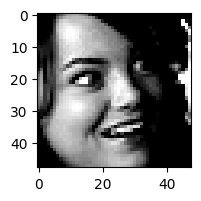

In [29]:
from torchvision.io import read_image

# Đọc một ảnh
img_path = '/content/train/happy/Training_10066226.jpg'
img_tensor = read_image(img_path)

# Hiển thị thông tin về tensor ảnh
print(img_tensor.shape)  # In ra kích thước của tensor
print(img_tensor.dtype)  # In ra kiểu dữ liệu của tensor

minv = img_tensor.numpy().min()+50
maxv = img_tensor.numpy().max()-50

plt.figure(figsize=(2, 2))
plt.imshow(np.squeeze(img_tensor.numpy()),  cmap="gray", vmin=minv, vmax=maxv)